In [15]:
%load_ext autoreload
%autoreload 2
import numpy as np
from xgboost import XGBClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from source.read_open_dataset import DatasetOpenDataset, openDatasetParticipants
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL

FEATURE_SIZE = 16
UMAP_NEIGHTBORS = 15
N_EPOCHS = 2000
CLASS_LABELS = ['Sedentary', 'Light']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reading the dataset

In [16]:
# dataset = DatasetHARUML20(mode='leave-one-subject')
dataset = DatasetPAMAP2(mode='leave-one-subject')

dataset.loadData()

# dataset.Int_train[dataset.Int_train==2] = 1
# dataset.Int_train[dataset.Int_train==3] = 1

# dataset.Int_test[dataset.Int_test==2] = 1
# dataset.Int_test[dataset.Int_test==3] = 1

# dataset.Int_train[dataset.Int_train==1] = 4
# dataset.Int_train[dataset.Int_train==0] = 0
# dataset.Int_train[dataset.Int_train==2] = 0
# dataset.Int_train[dataset.Int_train==3] = 0
# dataset.Int_train[dataset.Int_train==4] = 1

# dataset.Int_test[dataset.Int_test==1] = 4
# dataset.Int_test[dataset.Int_test==0] = 0
# dataset.Int_test[dataset.Int_test==2] = 0
# dataset.Int_test[dataset.Int_test==3] = 0
# dataset.Int_test[dataset.Int_test==4] = 1



dataset.Int_train[dataset.Int_train==1] = 0
dataset.Int_train[dataset.Int_train==2] = 0
dataset.Int_train[dataset.Int_train==3] = 1

dataset.Int_test[dataset.Int_test==1] = 0
dataset.Int_test[dataset.Int_test==2] = 0
dataset.Int_test[dataset.Int_test==3] = 1

In [17]:
print('Unique Labels (intensities): {}'.format(np.unique(dataset.Int_train)))
print('Signals: {}'.format(dataset.signals))

# print('Vigorous windows: {}'.format( np.array(np.unique(dataset.Int_train, return_counts=True)).T))
print('Non-vigorous windows: {}'.format( np.count_nonzero(dataset.Int_train ==0) ))
print('Vigorous windows: {}'.format( np.count_nonzero(dataset.Int_train ==1 ) ))
print('Sedentary windows: {}  Light windows: {}'.format(len(dataset.Int_train[dataset.Int_train == 0]), len(dataset.Int_train[dataset.Int_train == 1])))

Unique Labels (intensities): [0. 1.]
Signals: ['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 'handGyro1', 'handGyro2', 'handGyro3', 'handMagne1', 'handMagne2', 'handMagne3']
Non-vigorous windows: 5313
Vigorous windows: 861
Sedentary windows: 5313  Light windows: 861


# Data preparation

In [89]:
# Preparing data
ts_train = TSerie(dataset.X_train[:,:,:3], dataset.Int_train)
ts_test = TSerie(dataset.X_test[:,:,:3], dataset.Int_test)

ts_train.center()
ts_test.center()

ts_train.folding_features_v2()
ts_test.folding_features_v2()

# Engenharia de features

In [90]:

# Getting features
model = UMAP_FL(n_components=FEATURE_SIZE,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
ts_train.features = model.fit_transform(ts_train.features)
# ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
ts_test.features = model.transform(ts_test.features)

In [91]:

# Getting features
model_vis = UMAP_FL(n_components=2,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
train_proj = model_vis.fit_transform(ts_train.features)
test_proj = model_vis.transform(ts_test.features)

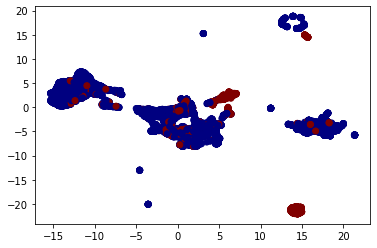

In [92]:
import matplotlib.pyplot as plt

plt.scatter(train_proj[:,0], train_proj[:,1], c = ts_train.y, cmap='jet')


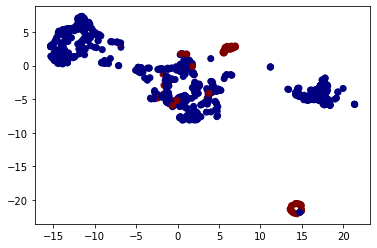

In [93]:
plt.scatter(test_proj[:,0], test_proj[:,1], c = ts_test.y, cmap='jet')

## Risk Minimization - SVM

0.8341640612987545
0.9864864864864865


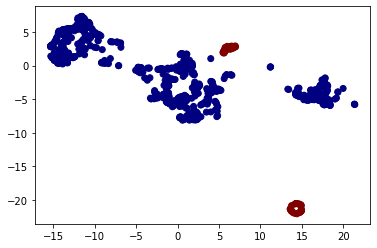

In [100]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=1)
# clf = SVC(kernel="linear", C=0.05)

clf.fit(ts_train.features, ts_train.y)

train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

# print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))

print(metrics.balanced_accuracy_score(ts_test.y, test_pr))
print(metrics.precision_score(ts_test.y, test_pr))

plt.scatter(test_proj[:,0], test_proj[:,1], c = test_pr, cmap='jet')

In [105]:
from sklearn.svm import SVC

# clf = SVC(gamma='auto', C=1)
clf = SVC(kernel="rbf", C=1)

clf.fit(ts_train.features, ts_train.y)

train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

# print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))

print(metrics.balanced_accuracy_score(ts_test.y, test_pr))
print(metrics.precision_score(ts_test.y, test_pr))

0.8341640612987545
0.9864864864864865


In [106]:
from sklearn.svm import SVC

# clf = SVC(gamma='auto', C=1)
clf = SVC(kernel="poly", C=1)

clf.fit(ts_train.features, ts_train.y)

train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

# print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))

print(metrics.balanced_accuracy_score(ts_test.y, test_pr))
print(metrics.precision_score(ts_test.y, test_pr))

0.8341640612987545
0.9864864864864865


In [107]:
from sklearn.svm import SVC

# clf = SVC(gamma='auto', C=1)
clf = SVC(kernel="sigmoid", C=1)

clf.fit(ts_train.features, ts_train.y)

train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

# print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))

print(metrics.balanced_accuracy_score(ts_test.y, test_pr))
print(metrics.precision_score(ts_test.y, test_pr))

0.49738608989800626
0.12643678160919541


In [104]:
from sklearn.svm import SVC

clf = SVC(gamma='auto', C=1)
# clf = SVC(kernel="rbf", C=0.05)

clf.fit(ts_train.features, ts_train.y)

train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

# print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))

print(metrics.balanced_accuracy_score(ts_test.y, test_pr))
print(metrics.precision_score(ts_test.y, test_pr))

0.8387512172620573
0.9866666666666667


In [109]:
from sklearn.svm import SVC

# clf = SVC(gamma='auto', C=1)
# clf = SVC(kernel="rbf", C=0.2)
clf = SVC(kernel="rbf", C=0.05)

clf.fit(ts_train.features, ts_train.y)

train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

# print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))

print(metrics.balanced_accuracy_score(ts_test.y, test_pr))
print(metrics.precision_score(ts_test.y, test_pr))

0.8020539695556352
0.9850746268656716


## Risk Minimization -  Neural Network model

0.8433383732253601
0.9868421052631579


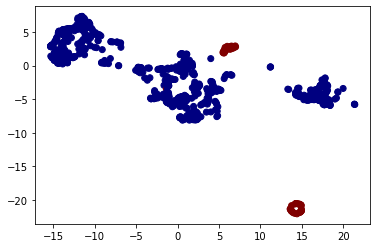

In [127]:
from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(random_state=1, max_iter=4000, hidden_layer_sizes =(1024,512))
# clf = MLPClassifier(random_state=1, max_iter=40q0, hidden_layer_sizes =(128,128))
clf = MLPClassifier(random_state=1, max_iter=400, hidden_layer_sizes =(128), activation='logistic')
# clf = MLPClassifier(random_state=1, max_iter=4000, hidden_layer_sizes =(1))
# clf = MLPClassifier(random_state=1, max_iter=4000, hidden_layer_sizes =(2))
clf.fit(ts_train.features, ts_train.y)

train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

# print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))
print(metrics.balanced_accuracy_score(ts_test.y, test_pr))
print(metrics.precision_score(ts_test.y, test_pr))

plt.scatter(test_proj[:,0], test_proj[:,1], c = test_pr, cmap='jet')

# Straight-forward Classifier


In [128]:

from sklearn.tree import DecisionTreeClassifier

# clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
# clf = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)

clf = DecisionTreeClassifier(random_state=0)
clf.fit(ts_train.features, ts_train.y)


train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

In [129]:
# print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))
print(metrics.balanced_accuracy_score(ts_test.y, test_pr))
print(metrics.precision_score(ts_test.y, test_pr))

0.8145981753882425
0.5161290322580645


# Plugin - Linear Discriminant Analysis


In [130]:
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split


In [131]:
X_train = ts_train.features
Y_train = ts_train.y

x_test = ts_test.features
y_test = ts_test.y

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1)

In [133]:
lda = LinearDiscriminantAnalysis(solver="svd", shrinkage=None, tol=0.0001)
lda.fit(x_train, y_train)

y_pred = lda.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

0.9551515151515152
0.8341640612987545
0.9864864864864865


In [134]:
lda = LinearDiscriminantAnalysis(solver="svd", shrinkage=None, tol=0.1)
lda.fit(x_train, y_train)

y_pred = lda.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

0.953939393939394
0.8334657372764082
0.9733333333333334


In [137]:
lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage=None)
lda.fit(x_train, y_train)

y_pred = lda.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

0.9551515151515152
0.8341640612987545
0.9864864864864865


In [136]:
lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage='auto')
lda.fit(x_train, y_train)

y_pred = lda.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

0.9551515151515152
0.8341640612987545
0.9864864864864865


In [138]:
lda = LinearDiscriminantAnalysis(solver="eigen", shrinkage=None)
lda.fit(x_train, y_train)

y_pred = lda.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

0.9551515151515152
0.8341640612987545
0.9864864864864865


In [139]:
lda = LinearDiscriminantAnalysis(solver="eigen", shrinkage='auto')
lda.fit(x_train, y_train)

y_pred = lda.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

0.9551515151515152
0.8341640612987545
0.9864864864864865


In [150]:
def get_pred(test_neigh):
  c10 = 1
  c01 = 1
  p1 = np.mean(y_train)
  p0 = 1 - np.mean(y_train)
  Lambda = y_train[test_neigh].mean(axis=1)/(1-y_train[test_neigh].mean(axis=1))
  eta = (c10*p0)/(c01*p1)
  # print(eta)
  # print(Lambda)
  y_pred = (Lambda>eta)*1
  return y_pred


In [152]:
n_neighbors = 5
neigh = NearestNeighbors(algorithm='auto', n_neighbors=n_neighbors, leaf_size=30, metric='euclidean')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

0.9551515151515152
0.8341640612987545
0.9864864864864865


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [155]:
n_neighbors = 5
neigh = NearestNeighbors(algorithm='ball_tree', n_neighbors=n_neighbors, leaf_size=30, metric='euclidean')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

0.9551515151515152
0.8341640612987545
0.9864864864864865


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [159]:
n_neighbors = 1
neigh = NearestNeighbors(algorithm='auto', n_neighbors=n_neighbors, leaf_size=30, metric='euclidean')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

0.9272727272727272
0.8336579365486136
0.7333333333333333


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [171]:
n_neighbors = 5
neigh = NearestNeighbors(algorithm='kd_tree', n_neighbors=n_neighbors, leaf_size=1, metric='euclidean')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

0.9551515151515152
0.8341640612987545
0.9864864864864865


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [172]:
n_neighbors = 5
neigh = NearestNeighbors(algorithm='brute', n_neighbors=n_neighbors, leaf_size=25, metric='manhattan')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

0.9551515151515152
0.8341640612987545


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [160]:
n_neighbors = 2
neigh = NearestNeighbors(algorithm='auto', n_neighbors=n_neighbors, leaf_size=25, metric='cosine')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

6.1875808538163e-05
0.9527272727272728
0.8327674132540618


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [161]:
n_neighbors = 2
neigh = NearestNeighbors(algorithm='brute', n_neighbors=n_neighbors, leaf_size=25, metric='cosine')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

6.1875808538163e-05
0.9527272727272728
0.8327674132540618


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5, 1.0, 'rf - test')

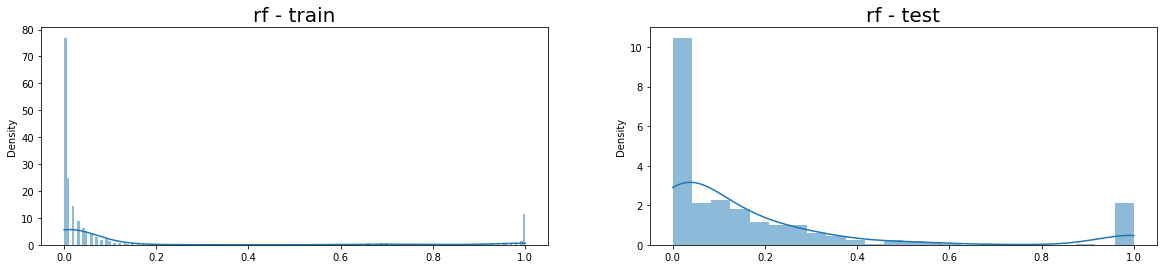

In [291]:
rf = RandomForestClassifier()    
# rf = SVC(probability=True, C=0.01)
rf.fit(x_train, y_train)

pred_probs_train = rf.predict_proba(x_train)[:,1]
pred_probs_test = rf.predict_proba(x_test)[:,1]
pred_probs_valid = rf.predict_proba(x_val)[:,1]

model_to_probs = {'train': pred_probs_train, 'test': pred_probs_test, 'valid': pred_probs_valid}

plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
sns.histplot(pred_probs_train, kde=True, stat="density", linewidth=0)
plt.title("rf - train", fontsize=20)

plt.subplot(1,2,2)
sns.histplot(pred_probs_test, kde=True, stat="density", linewidth=0)
plt.title("rf - test", fontsize=20)

In [292]:
# pred_probs

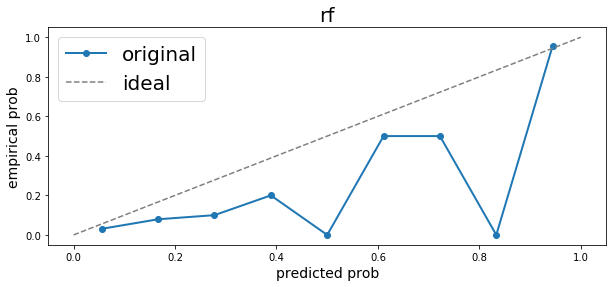

In [293]:
pred_probs = model_to_probs['test']
pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

empirical_probs = []
pred_probs_midpoints = []

for i in range(len(pred_probs_space)-1):
    vals = y_test[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]
    # print(vals)
    if len(vals) != 0:
        empirical_probs.append(np.mean(vals))
    else:
        empirical_probs.append(0)
    pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

plt.figure(figsize=(10,4))
plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
plt.title("rf", fontsize=20)
plt.xlabel('predicted prob', fontsize=14)
plt.ylabel('empirical prob', fontsize=14)

plt.plot([0,1],[0,1],linestyle='--',color='gray')
plt.legend(['original', 'ideal'], fontsize=20)
plt.savefig('empirical.png', bbox_inches='tight')
plt.show()

Brier score of  0.04982012121212122
Brier score of  0.0426926112245538


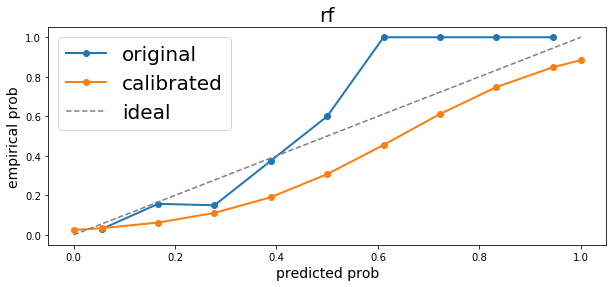

In [298]:
#train calibration model
lr_model = LogisticRegression()
lr_model.fit(model_to_probs['test'].reshape(-1,1), y_test)

pred_probs = model_to_probs['valid']
pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

empirical_probs = []
pred_probs_midpoints = []

for i in range(len(pred_probs_space)-1):
    vals = y_val[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]
    if len(vals) != 0:
        empirical_probs.append(np.mean(vals))
    else:
        empirical_probs.append(0)
    # empirical_probs.append(np.mean())
    pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

calibrated_probs = lr_model.predict_proba(np.array([0.0]+pred_probs_midpoints+[1.0]).reshape(-1,1))[:,1]
print('Brier score of ', brier_score_loss(y_test, model_to_probs['test']))
print('Brier score of ', brier_score_loss(y_test, lr_model.predict_proba(model_to_probs['test'].reshape(-1,1))[:,1]))
# print('Balanced score of ', balanced_accuracy_score(y_test, lr_model.predict_proba(model_to_probs['test'].reshape(-1,1))[:,1]))

plt.figure(figsize=(10,4))
plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
plt.title("rf", fontsize=20)
plt.xlabel('predicted prob', fontsize=14)
plt.ylabel('empirical prob', fontsize=14)

plt.plot([0.0]+pred_probs_midpoints+[1.0], calibrated_probs, linewidth=2, marker='o')
plt.plot([0,1],[0,1],linestyle='--',color='gray')

plt.legend(['original', 'calibrated', 'ideal'], fontsize=20)
plt.savefig('calibration.png', bbox_inches='tight')
plt.show()

model_str_to_calibrator = lr_model

In [278]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, balanced_accuracy_score, precision_score, roc_curve, auc, confusion_matrix

clf = RandomForestClassifier(random_state=1)    
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)[:,1]


tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(metrics.balanced_accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print('Falso positivo:', fp)

0.8370534570242427
0.8823529411764706
Falso positivo: 10


In [288]:

c01 = 10
c10 = 1



print('Custo total:', fn*c01+fp*c10)

Custo total: 361


In [289]:
nu = c10*(1-np.mean(y_test))/(c01*np.mean(y_test))
t = nu/(1+nu)

y_pred_o = y_prob>t

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_o).ravel()
print(metrics.balanced_accuracy_score(y_test, y_pred_o))
print(metrics.precision_score(y_test, y_pred_o))

print('Custo total:', fn*c01+fp*c10)
# print('Falso negativo:', fn*c01)
print('Falso positive:', fp)

0.8294679924145354
0.6936936936936937
Custo total: 354
Falso positive: 34


In [267]:

# print(metrics.reca(y_test, y_pred_o))

Custo total: 37
Falso negativo: 36
